In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
import pandas as pd

# Directly use column names (from the NSL-KDD documentation)
col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment",
    "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Load the data directly
url = 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt'
df = pd.read_csv(url, names=col_names)


In [3]:
# Step 2: Encode categorical columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

In [4]:
# Step 3: Drop the label column (unsupervised task)
X = df.drop("label", axis=1)

In [5]:
# Step 4: Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Step 5: Train Isolation Forest
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_scaled)
predictions = model.predict(X_scaled)

In [7]:
# Step 6: Convert predictions (-1 = anomaly, 1 = normal)
df['anomaly'] = [1 if x == -1 else 0 for x in predictions]


anomaly
0    113375
1     12598
Name: count, dtype: int64


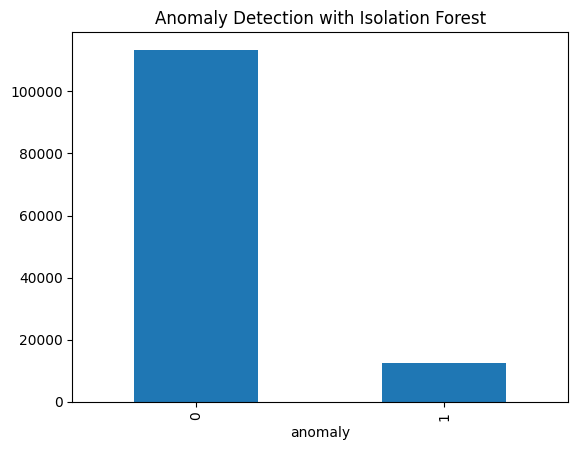

In [8]:
# Step 7: Show result
print(df['anomaly'].value_counts())
df['anomaly'].value_counts().plot(kind='bar', title="Anomaly Detection with Isolation Forest")
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

In [10]:
# Step 1: Prepare the same scaled data (X_scaled)

# Step 2: Build Autoencoder Model
input_dim = X_scaled.shape[1]
encoding_dim = 14

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation="relu")(input_layer)
decoded = layers.Dense(input_dim, activation="sigmoid")(encoded)
autoencoder = models.Model(input_layer, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [11]:
# Step 3: Train the autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=10, batch_size=256, shuffle=True, validation_split=0.1)

Epoch 1/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1119 - val_loss: 0.0154
Epoch 2/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0130 - val_loss: 0.0081
Epoch 3/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0072 - val_loss: 0.0052
Epoch 4/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 5/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 6/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 7/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 8/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/10
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0014


In [12]:
# Step 4: Calculate reconstruction error
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)


3937/3937 ━━━━━━━━━━━━━━━━━━━━ 4s 952us/step


In [13]:
# Step 5: Set a threshold for anomaly
threshold = np.percentile(mse, 90)
df['anomaly_ae'] = [1 if error > threshold else 0 for error in mse]


anomaly_ae
0    113375
1     12598
Name: count, dtype: int64


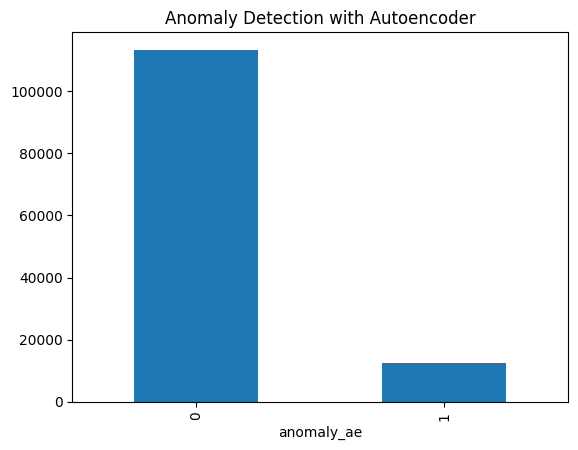

In [14]:
# Step 6: Show result
print(df['anomaly_ae'].value_counts())
df['anomaly_ae'].value_counts().plot(kind='bar', title="Anomaly Detection with Autoencoder")
plt.show()